In [18]:
from typing import TypedDict, List

from langchain.chains import RetrievalQA
from langgraph.graph import StateGraph, END
from langchain.prompts import ChatPromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_ollama import OllamaEmbeddings, OllamaLLM

# Podział dokumentów na fragmenty
splitter = RecursiveCharacterTextSplitter(chunk_size=100, chunk_overlap=25)
docs = splitter.create_documents([text])

# Tworzymy embeddingi przez Ollama
embeddings = OllamaEmbeddings(model="phi4")

# Tworzymy bazę Chroma
db = Chroma.from_documents(docs, embeddings)

**Dokument wejściowy**.

In [ ]:
text = """
Warszawa jest stolicą Polski. Kraków był dawną stolicą Polski i jest znany z zabytków.
Gdańsk leży nad Morzem Bałtyckim. Wrocław słynie z mostów i krasnali.
"""

Podział dokumentów na fragmenty.

In [19]:
docs

[Document(metadata={}, page_content='Warszawa jest stolicą Polski. Kraków był dawną stolicą Polski i jest znany z zabytków.'),
 Document(metadata={}, page_content='Gdańsk leży nad Morzem Bałtyckim. Wrocław słynie z mostów i krasnali.')]

In [13]:


retriever_llm = Ollama(model="phi4")

retriever_agent = RetrievalQA.from_chain_type(
    llm=retriever_llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

In [14]:
template = """Odpowiedz krótko na pytanie, używając kontekstu poniżej:

Kontekst:
{context}

Pytanie: {question}
Odpowiedź:
"""

prompt = ChatPromptTemplate.from_template(template)

generator_llm = Ollama(model="phi4")

def generate_answer(question, context):
    formatted_prompt = prompt.format(context=context, question=question)
    response = generator_llm.invoke(formatted_prompt)
    return response


In [15]:


# Definiujemy stan przepływu
class GraphState(TypedDict):
    question: str
    documents: List[str]
    answer: str

graph = StateGraph(GraphState)

# Funkcja węzła Retrieval
def retrieve(state):
    question = state["question"]
    result = retriever_agent.invoke(question)
    documents = [result['result']]
    return {"documents": documents, "question": question}

# Funkcja węzła Generation
def generate(state):
    question = state["question"]
    documents = "\n".join(state["documents"])
    answer = generate_answer(question, documents)
    return {"answer": answer}

# Dodajemy węzły
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)

# Definiujemy przepływ
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", END)

# Kompilujemy graf
rag_graph = graph.compile()

In [16]:
question = "Które miasto w Polsce jest znane z mostów?"

result = rag_graph.invoke({"question": question})

print("Odpowiedź:", result["answer"])

Odpowiedź: Wrocław jest znane z mostów.




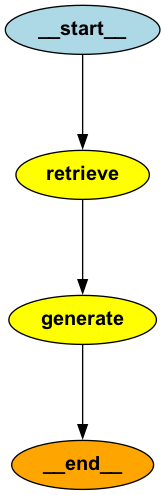

In [17]:
from IPython.display import Image

# Zakładając, że masz już stworzony 'rag_graph'
rag_graph.get_graph().draw_png("graph.png")

# Wyświetlenie grafu (w Jupyter Notebook lub Google Colab)
Image(filename="graph.png")